<a href="https://colab.research.google.com/github/Andrew-Haney/DS-Unit-2-Linear-Models/blob/master/Andrew_Haney_LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [50]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [47]:
import pandas as pd
from sklearn.metrics import plot_confusion_matrix, classification_report
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

def wrangle(f_path1, f_path2 = None):
  if f_path2:
    df = pd.merge(pd.read_csv(f_path1, 
                  na_values=[0, -2.000000e-08],
                  parse_dates=['date_recorded']),
                  pd.read_csv(f_path2)).set_index('id')

    df['needs_repair'] = (df['status_group'] != 'functional').astype(int)
    df.drop(columns= 'status_group', inplace= True)

  else:
    df = pd.read_csv(f_path1, 
                     na_values=[0, -2.000000e-08],
                     parse_dates=['date_recorded'],
                     index_col='id')
    
  df.drop(columns=['recorded_by'], inplace=True)
  
  df['age_of_pump'] = df['date_recorded'].dt.year - df['construction_year']
  df.drop(columns='date_recorded', inplace=True)

  cutoff = 100
  drop_cols = [col for col in df.select_dtypes('object').columns
              if df[col].nunique() > cutoff]
  df.drop(columns=drop_cols, inplace=True)
  dupe_cols = [col for col in df.head(15).T.duplicated().index
               if df.head(15).T.duplicated()[col]]
  df.drop(columns=dupe_cols, inplace=True)

  return df

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [51]:
df['needs_repair'] = df['needs_repair'] = (df['status_group'] != 'functional').astype(int)
df.drop(columns= 'status_group', inplace= True)

In [52]:
target = 'needs_repair'

X = df.drop(columns= target)
y = df[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [53]:
print('Baseline Acc is : ', y_train.value_counts(normalize= True).max())

Baseline Acc is :  0.5429713804713805


In [55]:
model_rf = make_pipeline(OrdinalEncoder(),
                         SimpleImputer(),
                         RandomForestClassifier(n_estimators = 50, random_state= 42)
                         )

In [56]:
model_rf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['date_recorded', 'funder', 'installer',
                                      'wpt_name', 'basin', 'subvillage',
                                      'region', 'lga', 'ward', 'public_meeting',
                                      'recorded_by', 'scheme_management',
                                      'scheme_name', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_t...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                               

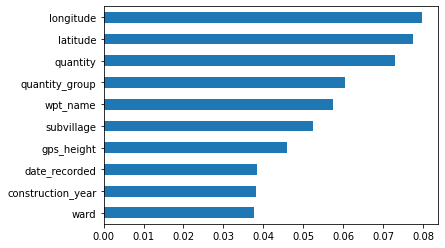

In [60]:
importances = model_rf.named_steps['randomforestclassifier'].feature_importances_
features = X_train.columns
pd.Series(importances, index= features).sort_values().tail(10).plot(kind= 'barh');

In [61]:
training_acc = model_rf.score(X_train, y_train)
val_acc = model_rf.score(X_val, y_val)

print('Training Accuracy is: ', training_acc)
print('Validation Accuracy is: ', val_acc)

Training Accuracy is:  0.999726430976431
Validation Accuracy is:  0.821969696969697


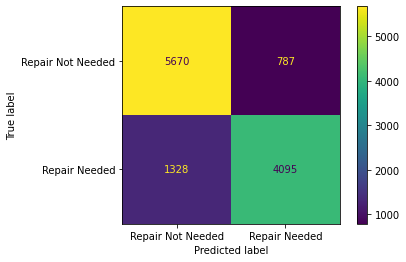

In [62]:
plot_confusion_matrix(model_rf,
                      X_val,
                      y_val,
                      display_labels = ['Repair Not Needed', 'Repair Needed'],
                      values_format = '.0f');